<a href="https://colab.research.google.com/github/OrJaku/road-sign-recognition/blob/master/road_sign_rec_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Instrukcja działania aplikacji uczenia oraz rozpoznawania znaków 

#####1. Plik *road_sign_rec_model.ipynb* środowkiska Google Colab (Jupiter Notebook) zawiera biblioteki potrzebne do zbidowania sieci neuronowej
#####2. W pliku nalezy zaimportować biblioteki oraz skopiować i rozpakować zbiór wcześniej przygotowanych znaków
######a. Do przygotowania plików (obrazów) potrzebnych do nauki sieci, służy aplikacja *property_app* napisana w lokalnym środkowski python
######b. Po uruchmieniu aplikacji (przez plik *run_property.py*) otrzymujemy menu wyboru:
    1 - Znajdź wybrane zdjęcia ze znakami lub wygeneruj listę etykiet <pliki sprawdzane w folderze */annotations* - z plikami JSON, plik CSV z listą wybranych plików zapisywany jest w folderze z aplikacją *property_app/output*'>
    2 - Kopiuj wybrane zdjęcia do nowego katalogu <kopiowanie plików (wybranych i dodanych wcześniej do pliku csv - konkretnego znaku), do nowej lokalizacji (np. pamięć flash lub dysk lokalny)
    3 - Wytnij znaki z pełnych zdjęć <wycinanie znaków z lokalizacji z pkt 2 do lokalnego folderu */home/kuba-ubuntu/img_mgr_out*>
    4 - Kopiuj wycięte zdjęcia do katalogów (train/valid/test) <kopiwanie wyciętych zdjęć do datasetów w lokalizacji '/home/kuba-ubuntu/Pobrane/Data' >
    9 - Dostępne znaki
    0 - Koniec

######c. Opcja 1. umożliwia wygenerowanie pliku CSV z nazwami obrazów zawierającymi wybrane przez nas znaki w pliku *run_property.py* w tabeli 'labels_list':
    labels_list = [ 
    "regulatory--keep-left--g1",
    "regulatory--keep-right--g2",
    "complementary--keep-right--g1",
    "regulatory--keep-left--g2",
    "regulatory--keep-right--g1",
    "complementary--keep-left--g1",
    "regulatory--yield--g1"]



##Biblioteki

In [3]:
import os, shutil, cv2, json
import pandas as pd
import numpy as np
from keras import layers, models, optimizers, metrics
from keras.preprocessing.image import ImageDataGenerator
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import time


## Pliki

In [ ]:
cd "/content/drive/My Drive/Colab Notebooks/Road_sign_rec"

/content/drive/My Drive/Colab Notebooks/Road_sign_rec


In [ ]:
cd "/content/drive/My Drive/Colab Notebooks/Road_sign_rec/data"

/content/drive/My Drive/Colab Notebooks/Road_sign_rec/data


In [ ]:
from google.colab import files

uploaded = files.upload()

### Kopiowanie obrazów treningowych na dysk Colab

In [1]:
cd "/content"

/content


In [4]:
try:
  os.mkdir("data")
except FileExistsError:
  pass
!cp "/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Data/Dataset_extend_zip.zip" "/content/data/Dataset_extend_zip.zip"

In [5]:
cd data

/content/data


In [6]:
!unzip -q Dataset_extend_zip.zip

In [7]:
data_folder = "/content/data/Data"
train_folder = os.path.join(data_folder, 'train_data')
signs_list_train = os.listdir(train_folder)
train_folders_length = {}
for signs_train in signs_list_train:
  train_folders_length[signs_train] = len(os.listdir(os.path.join(train_folder, signs_train)))
print(train_folders_length)
valid_folder = os.path.join(data_folder, 'valid_data')
signs_list_valid = os.listdir(valid_folder)
valid_folders_length = {}
for signs_val in signs_list_valid:
  valid_folders_length[signs_val] = len(os.listdir(os.path.join(valid_folder, signs_val)))
print(valid_folders_length)

{'limit60': 1144, 'limit80': 1236, 'cross': 1326, 'stop': 1314, 'limit70': 1264, 'nosign': 6036, 'othersign': 921, 'yield': 1665, 'no-overtaking': 367, 'limit40': 586, 'limit50': 1606}
{'limit60': 573, 'limit80': 618, 'cross': 663, 'stop': 506, 'limit70': 633, 'nosign': 2575, 'othersign': 461, 'yield': 832, 'no-overtaking': 184, 'limit40': 294, 'limit50': 803}


### Przygotowanie folderów

In [ ]:
base_dir = "Data/"

train_dir = os.path.join(base_dir, 'train_data')
try:
  os.mkdir(train_dir)
except FileExistsError:
  pass

test_dir = os.path.join(base_dir, 'test_data')
try:
  os.mkdir(test_dir)
except FileExistsError:
  pass


valid_dir = os.path.join(base_dir, 'valid_data')
try:
  os.mkdir(valid_dir)
except FileExistsError:
  pass

In [12]:
base_dir = "Data/"
train_dir = os.path.join(base_dir, 'train_data')
try:
  os.mkdir(train_dir)
except FileExistsError:
  pass
cross_train =  os.path.join(train_dir, 'cross')
stop_train =  os.path.join(train_dir, 'stop')
limit50_train =  os.path.join(train_dir, 'limit50')
nosign_train =  os.path.join(train_dir, 'nosign')
try:
  os.mkdir(nosign_train)
except FileExistsError:
  pass
try:
  os.mkdir(cross_train)
except FileExistsError:
  pass
try:
  os.mkdir(stop_train)
except FileExistsError:
  pass
try:
  os.mkdir(limit50_train)
except FileExistsError:
  pass

valid_dir = os.path.join(base_dir, 'valid_data')
try:
  os.mkdir(valid_dir)
except FileExistsError:
  pass

cross_val =  os.path.join(valid_dir, 'cross')
stop_val =  os.path.join(valid_dir, 'stop')
limit50_val =  os.path.join(valid_dir, 'limit50')
nosign_val =  os.path.join(valid_dir, 'nosign')

try:
  os.mkdir(nosign_val)
except FileExistsError:
  pass
try:
  os.mkdir(cross_val)
except FileExistsError:
  pass
try:
  os.mkdir(stop_val)
except FileExistsError:
  pass
try:
  os.mkdir(limit50_val)
except FileExistsError:
  pass

test_dir = os.path.join(base_dir, 'test_data')
try:
  os.mkdir(test_dir)
except FileExistsError:
  pass

cross_test =  os.path.join(test_dir, 'cross')
stop_test =  os.path.join(test_dir, 'stop')
limit50_test =  os.path.join(test_dir, 'limit50')
limit40_test =  os.path.join(test_dir, 'limit40')
limit60_test =  os.path.join(test_dir, 'limit60')
limit70_test =  os.path.join(test_dir, 'limit70')
limit80_test =  os.path.join(test_dir, 'limit80')
limit100_test =  os.path.join(test_dir, 'limit100')
yield_test =  os.path.join(test_dir, 'yield')
noovertaking_test =  os.path.join(test_dir, 'no-overtaking')
nosign_test =  os.path.join(test_dir, 'nosign')
othersign_test =  os.path.join(test_dir, 'othersign')



#### Ilość poszczegónych zdjęć

In [ ]:
# cross_origin_path = os.path.abspath("/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Data/information--pedestrians-crossing--g1/")
# stop_origin_path = os.path.abspath("/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Data/regulatory--stop--g1")
# limit50_origin_path = os.path.abspath("/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Data/regulatory--maximum-speed-limit-50--g1")
# nosign_path = os.path.abspath("/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Data/NoSign")
# nosign_path_2 = os.path.abspath("/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Data/NoSign2")



# print('Przejscie dla piszych: ',len(os.listdir(cross_origin_path)))
# print('Stop: ', len(os.listdir(stop_origin_path)))
# print('Ograniczenie do 50km/h: ', len(os.listdir(limit50_origin_path)))
# number_of_nosign = len(os.listdir(nosign_path)) + len(os.listdir(nosign_path_2))
# print('Brak znaku', number_of_nosign)


#### Kopowanie i podział zdjęć na treningowe, walidacyjne i testowe

---



In [ ]:

# # train cross
# for image_name in os.listdir(cross_origin_path)[0:1200]:
#   src = os.path.join(cross_origin_path, image_name)
#   dst = os.path.join(cross_train, image_name)
#   shutil.copyfile(src, dst)
# print("train cross copied")

# # validation cross
# for image_name in os.listdir(cross_origin_path)[1200:1800]:
#   src = os.path.join(cross_origin_path, image_name)
#   dst = os.path.join(cross_val, image_name)
#   shutil.copyfile(src, dst)
# print("validation cross copied")

# # test cross
# for image_name in os.listdir(cross_origin_path)[1800:]:
#   src = os.path.join(cross_origin_path, image_name)
#   dst = os.path.join(cross_test, image_name)
#   shutil.copyfile(src, dst)
# print("test cross copied")

# ##################################

# # train stop
# i=0
# for image_name in os.listdir(stop_origin_path)[0:900]:
#   i =+ 1
#   src = os.path.join(stop_origin_path, image_name)
#   dst = os.path.join(stop_train, image_name)
#   shutil.copyfile(src, dst)
#   if i == 200 or i == 400 or i == 700:
#     print(f"Copied {i} ")
# print("train stop copied")


# # validation stop
# for image_name in os.listdir(stop_origin_path)[901:1200]:
#   src = os.path.join(stop_origin_path, image_name)
#   dst = os.path.join(stop_val, image_name)
#   shutil.copyfile(src, dst)
#   if i == 1050:
#     print(f"Copied {i} ")
# print("validation stop copied")

# # test stop
# for image_name in os.listdir(stop_origin_path)[1201:]:
#   src = os.path.join(stop_origin_path, image_name)
#   dst = os.path.join(stop_test, image_name)
#   shutil.copyfile(src, dst)
#   if i == 1300:
#     print(f"Copied {i} ")
# print("test stop copied")


# ##########################

# # train limit50
# for image_name in os.listdir(limit50_origin_path)[0:400]:
#   src = os.path.join(limit50_origin_path, image_name)
#   dst = os.path.join(limit50_train, image_name)
#   shutil.copyfile(src, dst)
# print("train limit50 copied")

# # validation limit50
# for image_name in os.listdir(limit50_origin_path)[400:600]:
#   src = os.path.join(limit50_origin_path, image_name)
#   dst = os.path.join(limit50_val, image_name)
#   shutil.copyfile(src, dst)
# print("validation limit50 copied")

# # test limit50
# for image_name in os.listdir(limit50_origin_path)[600:]:
#   src = os.path.join(limit50_origin_path, image_name)
#   dst = os.path.join(limit50_test, image_name)
#   shutil.copyfile(src, dst)
# print("test limit50 copied")


# #########################


# # train NoSign
# for image_name in os.listdir(nosign_path)[0:1300]:
#   src = os.path.join(nosign_path, image_name)
#   dst = os.path.join(nosign_train, image_name)
#   shutil.copyfile(src, dst)
# print("train NoSign copied")

# # validation NoSign
# for image_name in os.listdir(nosign_path)[1300:1700]:
#   src = os.path.join(nosign_path, image_name)
#   dst = os.path.join(nosign_val, image_name)
#   shutil.copyfile(src, dst)
# print("validation NoSign copied")

# # test NoSign
# for image_name in os.listdir(nosign_path)[1700:]:
#   src = os.path.join(nosign_path, image_name)
#   dst = os.path.join(nosign_test, image_name)
#   shutil.copyfile(src, dst)
# print("test NoSign copied")


# # train NoSign2
# for image_name in os.listdir(nosign_path_2)[0:1300]:
#   src = os.path.join(nosign_path_2, image_name)
#   dst = os.path.join(nosign_train, image_name)
#   shutil.copyfile(src, dst)
# print("train NoSign2 copied")

# # validation NoSign2
# for image_name in os.listdir(nosign_path_2)[1300:1700]:
#   src = os.path.join(nosign_path_2, image_name)
#   dst = os.path.join(nosign_val, image_name)
#   shutil.copyfile(src, dst)
# print("validation NoSign2 copied")

# # test NoSign2
# for image_name in os.listdir(nosign_path_2)[1700:]:
#   src = os.path.join(nosign_path_2, image_name)
#   dst = os.path.join(nosign_test, image_name)
#   shutil.copyfile(src, dst)
# print("test NoSign2 copied")




train cross copied
validation cross copied
test cross copied
train stop copied


#### Przekształcanie plików .jpg na tensory - test

In [ ]:
# datagen = ImageDataGenerator(rotation_range=40,
#                              width_shift_range=0.2,
#                              height_shift_range=0.2,
#                              shear_range=0.2,
#                              zoom_range=0.2,
#                              horizontal_flip=True,
#                              fill_mode='nearest') 
                                  

In [ ]:
# from keras.preprocessing import image

# figure = plt.figure()
# fnames = [os.path.join(cross_train, fname) for fname in os.listdir(cross_train)]
# img_path = fnames[3]
# print(img_path)
# img = image.load_img(img_path, target_size=(100, 100))
# plt.imshow(img)
# x = image.img_to_array(img)
# x = x.reshape((1,) + x.shape)
# i=1
# for batch in datagen.flow(x, batch_size=1):
#   plt.subplot(2, 3, i+0)
#   plt
#   plt.imshow(image.array_to_img(batch[0]))
#   i+=1
#   if i%5==0:
#     break

# plt.show()
# figure

In [ ]:
# figure = plt.figure()
# fnames = [os.path.join(cross_train, fname) for fname in os.listdir(cross_train)]
# img_path = fnames[3]
# print(img_path)
# img = image.load_img(img_path, target_size=(100, 100))
# plt.imshow(img)
# figure

##Modele

###Przygotowanie parametrów

####Ustawienia genereatora zdjęć

In [24]:
batch_size = 64
picture_size = 96
class_mode = "categorical"

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=10,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.3,
                                  horizontal_flip=False,
                                  vertical_flip=False,                                   
                                  fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (picture_size,picture_size),
    batch_size = batch_size,
    class_mode = class_mode
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size = (picture_size,picture_size),
    batch_size = batch_size,
    class_mode = class_mode

)
number_of_classes = len(train_generator.class_indices)

Found 17465 images belonging to 11 classes.
Found 8142 images belonging to 11 classes.


####Parametry modelu

In [25]:
INIT_LR = 1e-3
epochs = 110
opt = optimizers.Adam(lr=INIT_LR, decay=INIT_LR / epochs)
metrics = 'categorical_accuracy'
activation = 'softmax'
loss = 'categorical_crossentropy'

###Model multi-classes classification - własny

In [26]:
dropout_1 = 0.4
dropout_2 = 0.3
dropout_3 = 0.3
dropout_4 = 0.4
dropout_5 = 0.3
dropout_6 = 0.25

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(picture_size, picture_size, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(dropout_1))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(dropout_2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(dropout_3))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(dropout_4))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(dropout_5))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout_6))
model.add(layers.Dense(number_of_classes))
model.add(layers.Activation(activation))

model.compile(
    loss=loss,
    optimizer=opt,
    metrics=[metrics]
    )
# model.summary()

###Pretrained model

In [ ]:
from keras.applications import VGG16
pretrain_model = VGG16(weights='imagenet',include_top=False,input_shape=(100, 100, 3))

In [ ]:
model = models.Sequential()
model.add(pretrain_model)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(number_of_classes))
model.add(layers.Activation(activation))
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['acc']
    )
model.summary()

###Fit model

In [27]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=200,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=50
)

time_stemp = time.strftime("%d%m%Y%H%M%S")
model_name = f'model_signs_{number_of_classes}_classes_{activation}_{time_stemp}.h5'
path_to_save = "/content/drive/My Drive/Colab Notebooks/Road_sign_rec"
model_path = os.path.join(path_to_save, model_name)
model.save(model_path)
print(f"Saved model as {model_name}")

Epoch 1/110
200/200 [==============================] - 40s 198ms/step - loss: 1.7261 - categorical_accuracy: 0.4356 - val_loss: 2.0469 - val_categorical_accuracy: 0.3256
Epoch 2/110
200/200 [==============================] - 39s 197ms/step - loss: 1.3064 - categorical_accuracy: 0.5629 - val_loss: 1.7481 - val_categorical_accuracy: 0.3672
Epoch 3/110
200/200 [==============================] - 39s 195ms/step - loss: 1.1320 - categorical_accuracy: 0.6155 - val_loss: 1.2780 - val_categorical_accuracy: 0.5600
Epoch 4/110
200/200 [==============================] - 39s 196ms/step - loss: 1.0238 - categorical_accuracy: 0.6437 - val_loss: 0.8846 - val_categorical_accuracy: 0.6781
Epoch 5/110
200/200 [==============================] - 39s 195ms/step - loss: 0.9236 - categorical_accuracy: 0.6715 - val_loss: 0.7067 - val_categorical_accuracy: 0.7300
Epoch 6/110
200/200 [==============================] - 39s 197ms/step - loss: 0.8438 - categorical_accuracy: 0.6913 - val_loss: 0.6620 - val_categoric

###Sprawdzenie modelu

####Przebieg uczenia 


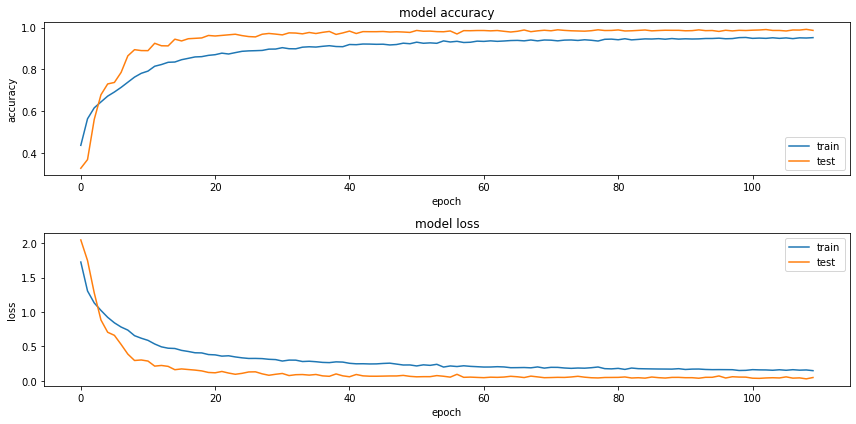

In [28]:
fig = plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()
fig

####Testowanie modelu

In [29]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(picture_size, picture_size),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=1,
        )

filenames = test_generator.filenames
classes_gen = test_generator.class_indices
classes_gen = test_generator.class_indices

loss_acc = model.evaluate(test_generator)
print(classes_gen)
print('loss= ', loss_acc[0])
print("acc= ", loss_acc[1])

Found 3492 images belonging to 11 classes.
3492/3492 [==============================] - 11s 3ms/step - loss: 0.0509 - categorical_accuracy: 0.9860
{'cross': 0, 'limit40': 1, 'limit50': 2, 'limit60': 3, 'limit70': 4, 'limit80': 5, 'no-overtaking': 6, 'nosign': 7, 'othersign': 8, 'stop': 9, 'yield': 10}
loss=  0.05093410983681679
acc=  0.9859679341316223


In [30]:
predict = model.predict_generator(test_generator,steps = len(filenames))
predict

array([[9.99079943e-01, 2.31516492e-06, 8.55037160e-06, ...,
        3.62260384e-04, 4.65277699e-05, 9.10576055e-05],
       [9.99893904e-01, 2.30931349e-07, 1.14492411e-06, ...,
        7.19188247e-05, 8.13660904e-07, 4.65792891e-06],
       [9.99977350e-01, 5.12525382e-08, 3.17839493e-07, ...,
        1.32045025e-05, 2.01236148e-07, 1.58201487e-06],
       ...,
       [6.77350266e-13, 1.88749502e-14, 2.21382768e-16, ...,
        1.96833608e-12, 3.91867114e-16, 1.00000000e+00],
       [4.90059271e-10, 4.52891946e-10, 7.85009766e-11, ...,
        2.68669798e-09, 6.43193068e-11, 1.00000000e+00],
       [7.14342474e-11, 1.82168798e-12, 9.63949081e-13, ...,
        1.74133125e-10, 2.10733340e-13, 1.00000000e+00]], dtype=float32)

In [31]:
from google.colab.patches import cv2_imshow

signs = test_generator.class_indices
prediction_list = []
memo_correct_percent = {}
for sign in signs:
  files = os.path.join(test_dir, sign)
  test_files = os.listdir(files)
  incorrect = 0
  for f in test_files:
    path_to_test = os.path.join(files, f)
    img = cv2.imread(path_to_test)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb,(picture_size,picture_size))
    img_resized_float = img_resized.astype("float32") / 255
    img_tensor = np.reshape(img_resized_float,[1,picture_size,picture_size,3])
    classes = (model.predict_classes(img_tensor)).tolist()
    for num, class_ in enumerate(signs):
      if classes[0] == num:
        classes = list(signs.keys())[list(signs.values()).index(num)]
    else:
      classes
    if classes != sign:
      # cv2_imshow(img)
      incorrect += 1 
  corrent_percent = round(100-(incorrect/len(test_files)*100))
  memo_correct_percent[sign] = corrent_percent
  prediction_note = f'{sign}: {incorrect} / {len(test_files)},  Poprawność: {corrent_percent}%'
  prediction_list.append(prediction_note)
  print(prediction_note)
mean_correct_percent = round(sum(memo_correct_percent.values()) / len(signs), 1)
print(f'Średnia poprawność predykcji: {mean_correct_percent}%')

cross: 1 / 409,  Poprawność: 100%
limit40: 9 / 98,  Poprawność: 91%
limit50: 5 / 312,  Poprawność: 98%
limit60: 4 / 191,  Poprawność: 98%
limit70: 5 / 211,  Poprawność: 98%
limit80: 3 / 206,  Poprawność: 99%
no-overtaking: 1 / 62,  Poprawność: 98%
nosign: 17 / 1334,  Poprawność: 99%
othersign: 5 / 155,  Poprawność: 97%
stop: 2 / 236,  Poprawność: 99%
yield: 6 / 278,  Poprawność: 98%
Średnia poprawność predykcji: 97.7%


###Zapis danych modelu i wyników do pliku tekstowego

In [32]:
time_date = time.strftime("%d/%m/%Y - %H:%M:%S")
with open("/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Log_data.txt", "a") as f:
  f.write(f"Model {time_date} \n")
  f.write(f"Funkcja aktywacji: {activation} \n")
  f.write(f"Liczba klas: {len(classes_gen)}\n")
  f.write(f"Ilość zdjęć treningowych: \n")
  for key, value in train_folders_length.items():
    f.write(f"\t{key}: {value}\n")
  f.write(f"Ilość zdjęć walidacyjnych: \n")
  for key, value in valid_folders_length.items():
    f.write(f"\t{key}: {value}\n")
  f.write(f"Parametry:\n \tEpochs: {epochs}\n \tMetrics: {metrics}\n \tLoss: {loss}\n \tClassification: {class_mode} \n")
  f.write(f"\tBatch size: {batch_size}\n")
  f.write(f"\tWielkość zdjęć: {picture_size}x{picture_size}px\n")
  f.write(f"\tIlość warstw modelu: {len(model.layers)}\n")
  f.write(f"\tDropout: 1 - {dropout_1}; 2 - {dropout_2}; 3 - {dropout_3}; 4 - {dropout_4}; 5 - {dropout_5}; 6 - {dropout_6}\n")
  f.write("\n")
  f.write("Wyniki: \n")
  f.write(f"\tSTRATA [loss]: {loss_acc[0]}\n")
  f.write(f"\tDOKŁADNOŚĆ [acc]: {loss_acc[1]}\n")
  f.write(f"\tIlość zdjęć testowych: {len(test_generator.filenames)}\n")
  for prediction in prediction_list:
    f.write(f"\t{prediction}\n")
  f.write(f"Średnia poprawność manualnej predykcji: {mean_correct_percent}% \n")
  f.write(f"Nazwa pliku: {model_name}")
  f.write("\n")
  f.write("-------------------------------------------------------------")
  f.write("\n\n")

###Zapis modelu (.json) i wag (.h5)

In [33]:
model_name_json = f'model_{len(classes_gen)}conv.json'
model_path = os.path.join("/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Data", model_name_json)
json_config = model.to_json()
with open(model_path, 'w') as json_file:
    json_file.write(json_config)

In [ ]:
model_name = 'model_signs_4_classes.h5'
model_path = os.path.join(base_dir, model_name)
model.save(model_path)

In [ ]:
model_name = 'model_signs_4_multi_classes_softmax.h5'
model_path = os.path.join(base_dir, model_name)
model.save(model_path)

In [ ]:
model_name = 'model_signs_4_multi_classes_sigmoid.h5'
model_path = os.path.join(base_dir, model_name)
model.save(model_path)

In [ ]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/Road_sign_rec/model_signs_9_classe_sigmoid_23052020.h5')

In [ ]:
figure = plt.figure()
files = os.path.join(test_dir, 'cross')
test_files = os.listdir(files)
path_to_test = os.path.join(files, test_files[100])
img = cv2.imread(path_to_test)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(picture_size,picture_size))
plt.imshow(img)
plt.show()

##Detekcja wideo

###Pliki i ścieżki

In [ ]:
video_path_input_directory = '/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Input'
video_file_name = 'warsaw_drive_test.mp4'
video_path_file = os.path.join(video_path_input_directory, video_file_name)
video_path_output = '/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Output'
print(video_path_file)
from google.colab.patches import cv2_imshow

/content/drive/My Drive/Colab Notebooks/Road_sign_rec/Input/warsaw_drive_test.mp4


In [ ]:
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  cap = cv2.VideoCapture(video_path_file)
  video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  cap_video_fps = int(cap.get(cv2.CAP_PROP_FPS))
  cap_video_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  cap_video_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  print("FPS", cap_video_fps)
  print("Length", video_length)
  writer = None
  (W, H) = (None, None)
  mean = np.array([100, 100, 100], dtype="float32")
  i = 0
  while True:
      i += 1
      print(f'{i} / {video_length}')
      (grabbed, frame) = cap.read()
      if not grabbed:
          break
      if W is None or H is None:
          (H, W) = frame.shape[:2]
      output = frame.copy()
      ss.setBaseImage(output)
      try:
        ss.switchToSelectiveSearchFast()
      except cv2.error:
        break
      ssresults = ss.process()
      for w, result in enumerate(ssresults):
          if w < 2000:
              x, y, w, h = result
              timage = output[y:y+h, x:x+w]
              resized = cv2.resize(timage, (100, 100), interpolation=cv2.INTER_AREA)
              resized = resized - mean
              img = np.expand_dims(resized, axis=0)
              out = model.predict(img/255.0, batch_size=10)
              if out[0][0] >= 0.99:
                  cv2.rectangle(output, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
      if writer is None:
          fourcc = cv2.VideoWriter_fourcc(*"MJPG")
          writer = cv2.VideoWriter('Output/out_video.mp4', 
                                   fourcc, 
                                   30,
                                   (W, H), 
                                   True,
                                   )
      writer.write(output)
      cv2_imshow(output)
  print("__END__")